In [28]:
import numpy as np
import tensorflow as tf
import librosa

from grog.audioreader import AudioReader
from grog.models.model import Model
from grog.models.infer import Inference
from grog.config import Config
from grog.util import pad_or_truncate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import itertools

%matplotlib inline
%load_ext autoreload
%autoreload 2

%set_env TF_FORCE_GPU_ALLOW_GROWTH=true

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [120]:
mix_path = "../../workspace/eval/2019-05-25/FADG0-0_MABW0-0.wav"
model_dir = "../../workspace/models/2019-05-25/model-timit-a/seeds"
config = Config()
#config.load_constants()
config.load_json("../../workspace/models/2019-05-25/model-timit-a/config.json")

inference = Inference(config)
mix, _ = librosa.load(mix_path, sr=8000)
mix_spec = librosa.core.stft(mix, n_fft=256, hop_length=64, window=np.hanning, center=False)

session, embedding_model, in_data, in_data, dropout_ff, dropout_rc = inference.prepare_session("../../workspace/models/2019-05-25/model-timit-a/seeds")
embeddings, N_samples = inference.estimate_embeddings(session, mix, embedding_model, in_data, dropout_ff, dropout_rc)
session.close()

Embeddings: 4
Calculating cluster visualisation...


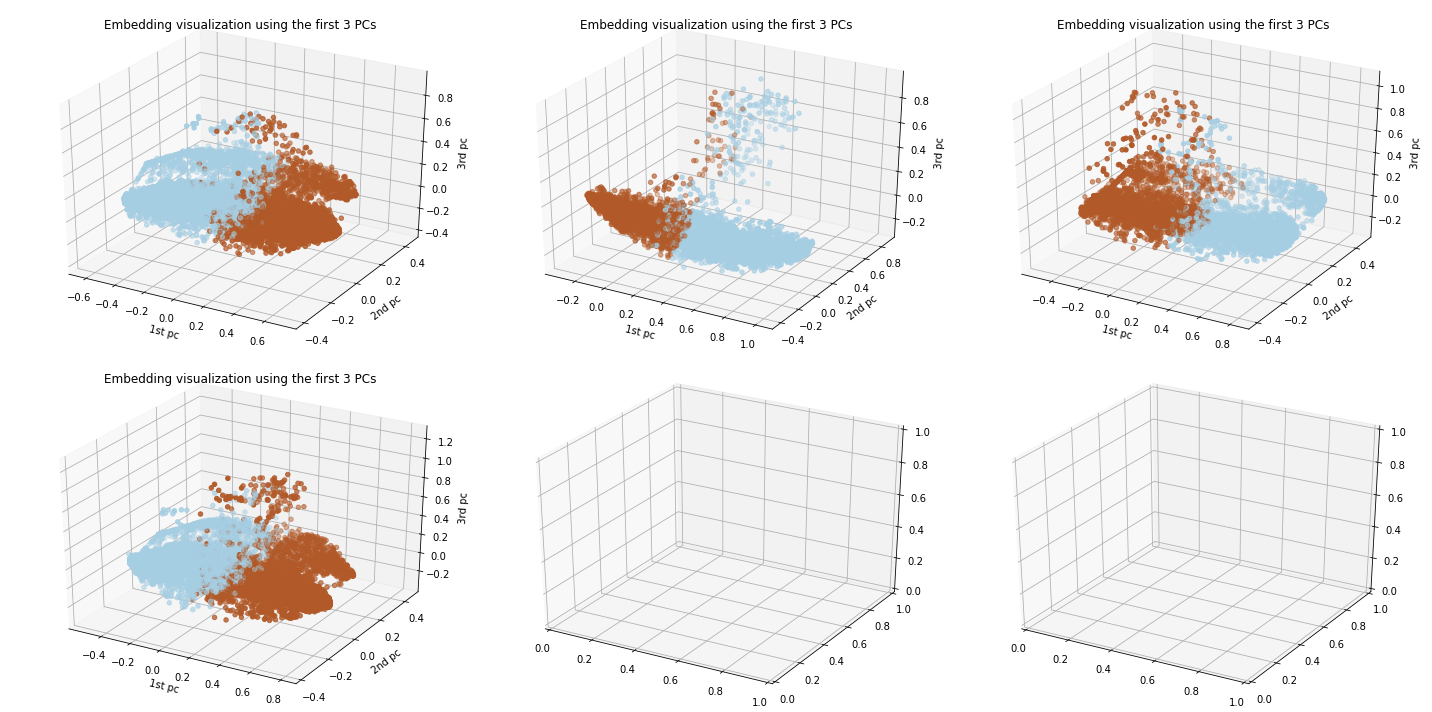

In [116]:
fig, axes = plt.subplots(len(embeddings) // 3 + 1, 3, figsize=(20,10), squeeze=False, subplot_kw={'projection': '3d'})
axes = np.array(axes).flatten()

print("Embeddings: %d" % len(embeddings))
print("Calculating cluster visualisation...")


windows_per_sample = 100
effective_ft_points = 129

init = 'k-means++'

for i, (embedding, data_batch) in enumerate(embeddings):
    ax = axes[i]
    
    in_data_np, in_phase_np, VAD_data_np = data_batch
    embedding = embedding.reshape(windows_per_sample * effective_ft_points, 40)
    #embedding = [embedding[i, j, :]
    #                for i, j in itertools.product(
    #                    range(windows_per_sample), range(effective_ft_points))
    #                if VAD_data_np[0, i, j] == 1]
    
    kmean = KMeans(algorithm='full', n_clusters=2, n_init=1, init=init)
    fitted = kmean.fit(embedding)
    init = fitted.cluster_centers_
    
    pca_Data = PCA(n_components=3).fit_transform(embedding)
    #ca_Data = TSNE(n_components=3).fit_transform(embedding_ac)

    #fig = plt.figure(1, figsize=(8, 6))
    #ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(pca_Data[:, 0], pca_Data[:, 1], pca_Data[:, 2],
                c=fitted.labels_, cmap=plt.cm.Paired)
    #ax.scatter(pca_Data[:, 0], pca_Data[:, 1], pca_Data[:, 2],
    #           cmap=plt.cm.Paired)
    ax.set_title('Embedding visualization using the first 3 PCs')
    ax.set_xlabel('1st pc')
    ax.set_ylabel('2nd pc')
    ax.set_zlabel('3rd pc')

plt.tight_layout()

Embeddings: 4
Calculating cluster visualisation...


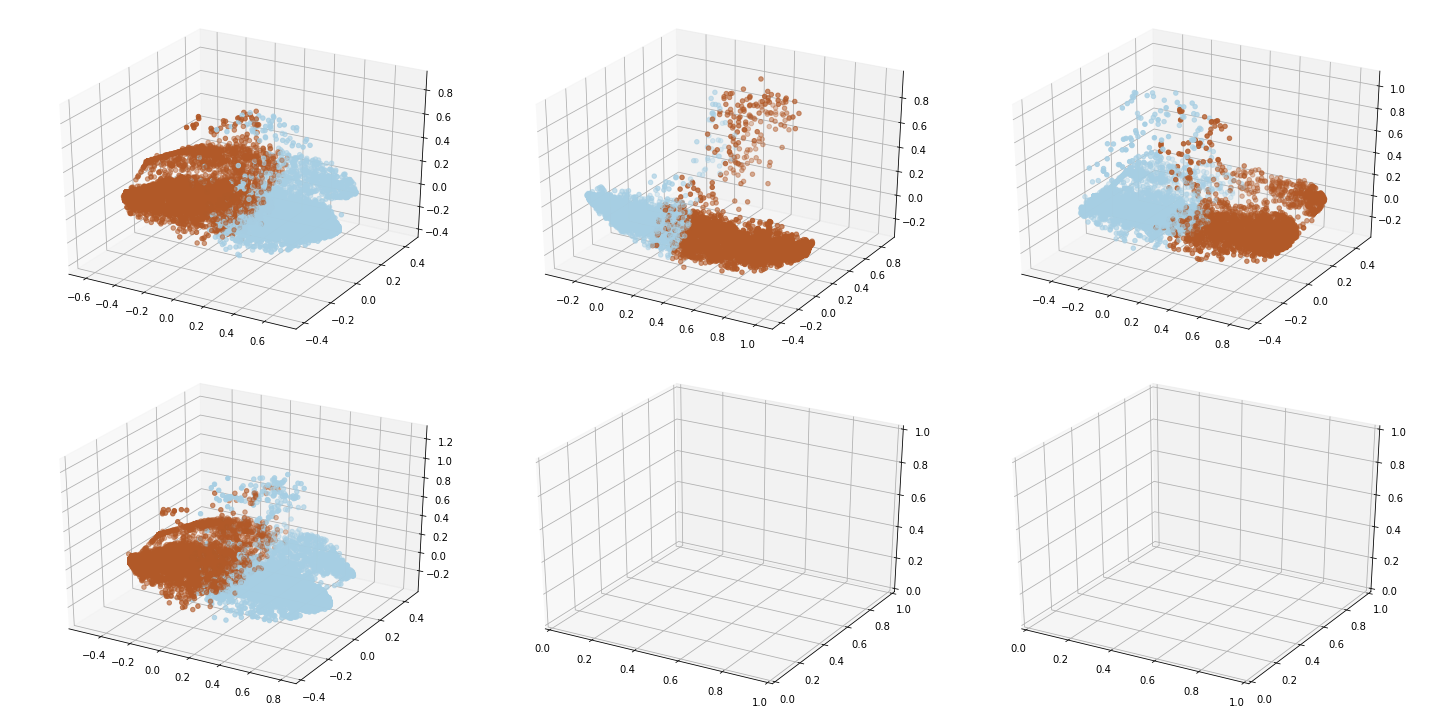

In [52]:
fig, axes = plt.subplots(len(embeddings) // 3 + 1, 3, figsize=(20,10), squeeze=False, subplot_kw={'projection': '3d'})
axes = np.array(axes).flatten()

print("Embeddings: %d" % len(embeddings))
print("Calculating cluster visualisation...")


windows_per_sample = 100
effective_ft_points = 129

kmean = KMeans(n_clusters=2, n_init=100)
for i, (embedding, data_batch) in enumerate(embeddings):
    ax = axes[i]
    
    in_data_np, in_phase_np, VAD_data_np = data_batch
    embedding = embedding.reshape(windows_per_sample * effective_ft_points, 40)

    fitted = kmean.fit(embedding)

    pca_Data = PCA(n_components=3).fit_transform(embedding)
    ax.scatter(pca_Data[:, 0], pca_Data[:, 1], pca_Data[:, 2],
                c=fitted.labels_, cmap=plt.cm.Paired)
plt.tight_layout()

In [91]:
# TODO: Adapt to known working example
windows_per_sample = 100
effective_ft_points = 129

global_embeddings = []
for i, (embedding, data_batch) in enumerate(embeddings):
    in_data_np, in_phase_np, VAD_data_np = data_batch
    
    embedding = [embedding[i, j, :]
                    for i, j in itertools.product(
                        range(windows_per_sample), range(effective_ft_points))
                    if VAD_data_np[0, i, j] == 1]
    
    embedding = np.array(embedding).reshape(-1, 40)
    
    global_embeddings.extend(embedding)

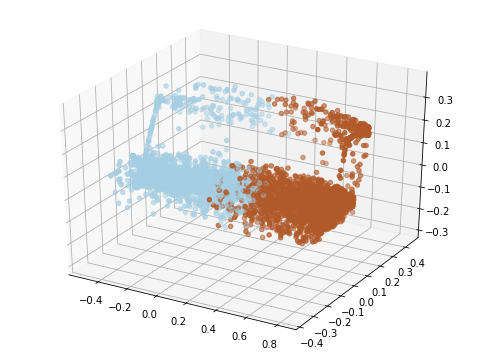

In [90]:
# Global k-means
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(len(embeddings) // 3 + 1, 3, i + 1, projection='3d')

kmean = KMeans(n_clusters=2, random_state=0).fit(global_embeddings)
pca_Data = PCA(n_components=3).fit_transform(global_embeddings)
ax.scatter(pca_Data[:, 0], pca_Data[:, 1], pca_Data[:, 2], c=kmean.labels_, cmap=plt.cm.Paired)

plt.tight_layout()

### Sparsity?

In [105]:
import scipy.sparse as sp

In [117]:
print(sp.issparse(global_embeddings))

for i, (embedding, data_batch) in enumerate(embeddings):
    print(sp.issparse(embedding))

False
False
False
False
False


## Spectrogram visualisation

## Order selection

In [92]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.utils import timedcall
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.elbow import elbow

In [93]:
embedding_size = windows_per_sample * effective_ft_points
sample = global_embeddings[embedding_size:2*embedding_size]

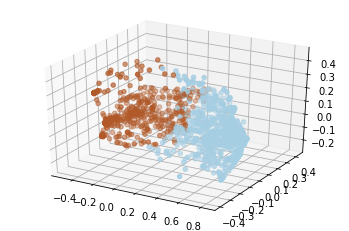

In [94]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')

kmean = KMeans(n_clusters=2)
fitted = kmean.fit(sample)
pca_Data = PCA(n_components=3).fit_transform(sample)
ax.scatter(pca_Data[:, 0], pca_Data[:, 1], pca_Data[:, 2], c=fitted.labels_, cmap=plt.cm.Paired)

### X-means

In [95]:
tolerance = 0.025
criterion = splitting_type.BAYESIAN_INFORMATION_CRITERION

amount_initial_centers = 1
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()
xmeans_instance = xmeans(sample, initial_centers, 3, tolerance=tolerance, criterion=criterion, ccore=True)
xmeans_instance.process()

In [96]:
centers = xmeans_instance.get_centers()
print(len(centers))

3


### Elbow

In [99]:
kmin, kmax = 1, 6
elbow_instance = elbow(sample, kmin, kmax)
elbow_instance.process()

amount_clusters = elbow_instance.get_amount()  # most probable amount of clusters
wce = elbow_instance.get_wce()  # total within-cluster errors for each K
print(amount_clusters, wce)

2 [955.2618855600176, 461.3905649454058, 400.43324596419313, 385.03787199117534, 386.7344589592393]


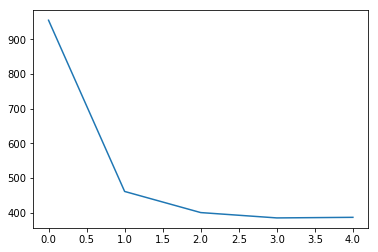

In [100]:
plt.plot(wce)

plt.show()